# Import and Environment Setup

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
import optuna

# Data Import

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_data = pd.concat([train, test], ignore_index=True)
# display information about datasets
print('Number of Training Examples = {}'.format(train.shape[0]))
print('Number of Test Examples = {}\n'.format(test.shape[0]))
print('Training X Shape = {}'.format(train.shape))
print('Training y Shape = {}\n'.format(train['Transported'].shape[0]))
print('Test X Shape = {}'.format(test.shape))
print('Test y Shape = {}\n'.format(test.shape[0]))
print(train.columns)
print(test.columns)
print(train.info())
print(train.describe())
train.sample(5)
cleaning_pipeline = []


Number of Training Examples = 8693
Number of Test Examples = 4277

Training X Shape = (8693, 14)
Training y Shape = 8693

Test X Shape = (4277, 13)
Test y Shape = 4277

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           851

# Correlation Matrix

C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\890241177.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)


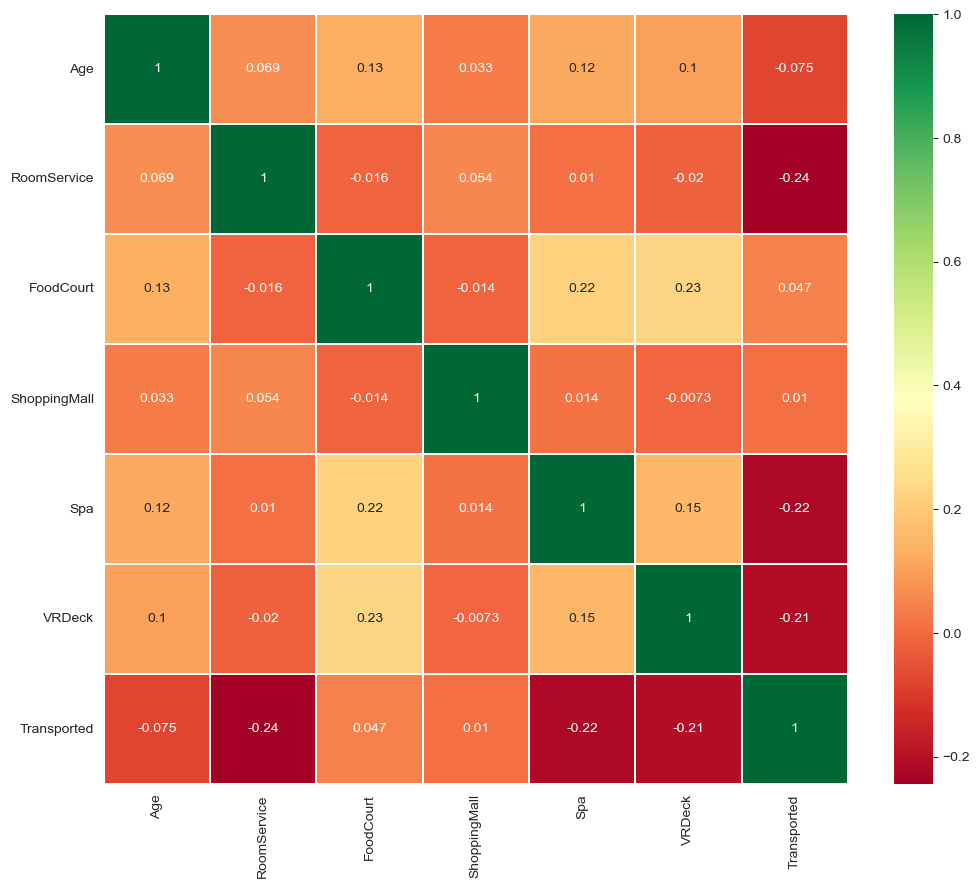

In [3]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.show()

# Version 1 Data Preprocessing

In [4]:
data_v1 = train.copy(deep=True)
# separate PassengerId  to two columns group and number (before and after the _) as int
def split_passenger_id(data):
    data['Group'], data['Number'] = data['PassengerId'].str.split('_', 1).str
    data['Group'] = data['Group'].astype(int)
    data['Number'] = data['Number'].astype(int)
    # drop PassengerId
    data.drop(['PassengerId'], axis=1, inplace=True)
    # count number of members in each group
    data['GroupSize'] = data.groupby('Group')['Group'].transform('count')
    return data
data_v1 = split_passenger_id(data_v1)
cleaning_pipeline.append(split_passenger_id)

C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\2827957064.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data['Group'], data['Number'] = data['PassengerId'].str.split('_', 1).str
C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\2827957064.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['Group'], data['Number'] = data['PassengerId'].str.split('_', 1).str


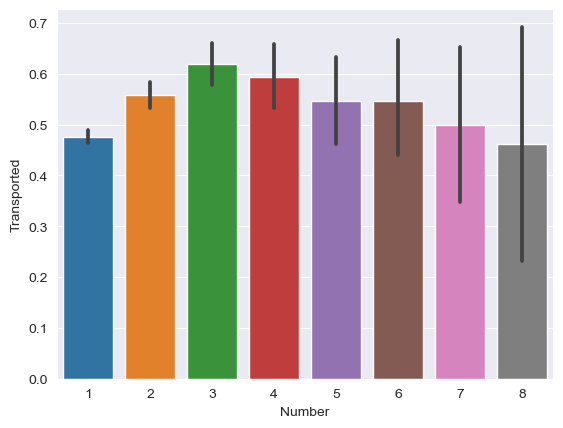

In [5]:
#Relationship between Number and Transported by percentage
sns.barplot(x='Number', y='Transported', data=data_v1)
plt.show()

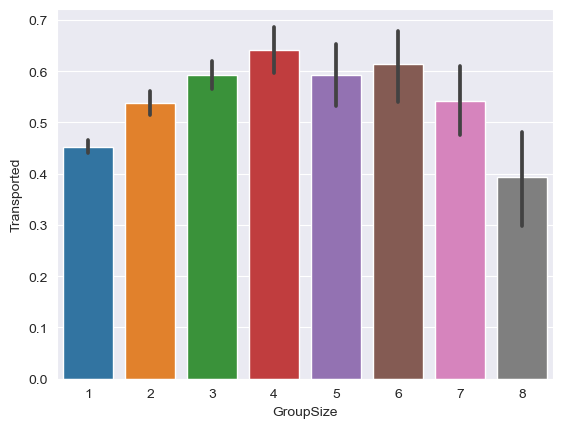

In [6]:
#Relationship between GroupSize and Transported by percentage
sns.barplot(x='GroupSize', y='Transported', data=data_v1)
plt.show()

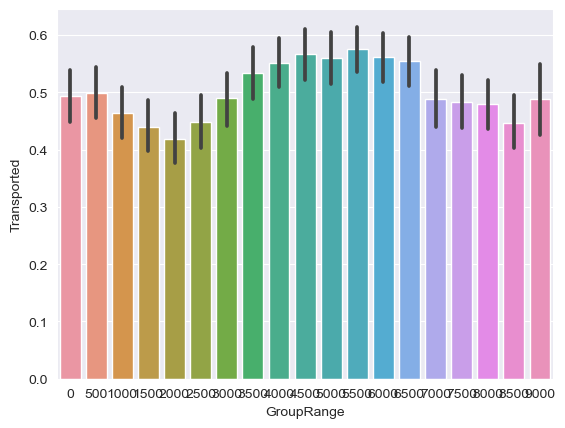

In [7]:
#Relationship between GroupRange (each 500 e.g. 1-500, 501-1000, etc.) and Transported by percentage
def group_range(data):
    data['GroupRange'] = data['Group'].apply(lambda x: (x // 500) * 500)
    return data
data_v1 = group_range(data_v1)
cleaning_pipeline.append(group_range)
sns.barplot(x='GroupRange', y='Transported', data=data_v1)
plt.show()

<Axes: xlabel='HomePlanet', ylabel='count'>

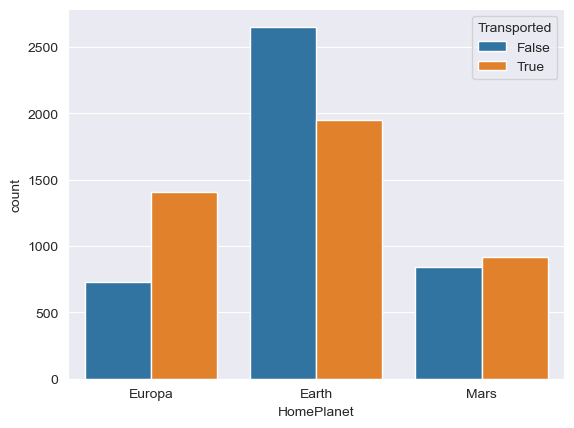

In [8]:
#Relationship between HomePlanet and Transported
sns.countplot(x='HomePlanet', hue='Transported', data=data_v1)

In [9]:
#checking if there are peoples with the same "Group" and different "HomePlanet" and print
grouped = data_v1.groupby('Group')['HomePlanet'].nunique().to_frame()
grouped[grouped['HomePlanet'] > 1]

,HomePlanet
Group,


In [10]:
data_v1[data_v1['HomePlanet'].isnull()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange
59,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True,64,2,2,0
113,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False,119,1,2,0
186,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True,210,1,1,0
225,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,242,1,1,0
234,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,251,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,NaN,False,E/582/P,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,Jurs Mone,False,9084,1,1,9000
8613,NaN,False,E/603/S,55 Cancri e,53.0,False,0.0,4017.0,0.0,13.0,3147.0,NaN,False,9194,1,2,9000
8666,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,Gian Perle,True,9248,1,1,9000
8674,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False,9257,1,1,9000


There are no people in the same group with different HomePlanet
so we can fill some of the missing values in HomePlanet with the HomePlanet of the other members in the same group


In [11]:
def fill_missing_home_planet(data):
    group_dict = {}
    for index, row in data.iterrows():
        group = row['Group']
        home_planet = row['HomePlanet']
        if pd.isnull(group) or pd.isnull(home_planet):
            continue
        group_dict[group] = home_planet
    for index, row in data.iterrows():
        group = row['Group']
        home_planet = row['HomePlanet']
        if pd.isnull(home_planet) and group in group_dict:
            data.at[index, 'HomePlanet'] = group_dict[group]
    return data
data_v1 = fill_missing_home_planet(data_v1)
cleaning_pipeline.append(fill_missing_home_planet)

In [12]:
data_v1[data_v1['HomePlanet'].isnull()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange
186,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True,210,1,1,0
225,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,242,1,1,0
234,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,251,1,1,0
274,NaN,True,G/41/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Oraryn Kirklander,True,303,1,1,0
286,NaN,True,G/42/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,0.0,0.0,Adriet Valezaley,True,315,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,NaN,True,F/1848/P,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Cobix Erle,True,9043,1,1,9000
8515,NaN,False,E/582/P,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,Jurs Mone,False,9084,1,1,9000
8666,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,Gian Perle,True,9248,1,1,9000
8674,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False,9257,1,1,9000


By searching some of the family names we can see that people with the same family name are from the same HomePlanet
so we can fill the missing values in HomePlanet with the HomePlanet of the other members in the same family (make

In [13]:
def name_split(data):
    data['FirstName'], data['LastName'] = data['Name'].str.split(' ', 1).str
    return data
data_v1 = name_split(data_v1)
cleaning_pipeline.append(name_split)
def fill_missing_home_planet_by_last_name(data):
    last_name_dict = {}

    for index, row in data.iterrows():
        last_name = row['LastName']
        home_planet = row['HomePlanet']
        if pd.isnull(last_name) or pd.isnull(home_planet):
            continue
        last_name_dict[last_name] = home_planet

    for index, row in data.iterrows():
        last_name = row['LastName']
        home_planet = row['HomePlanet']

        if pd.isnull(home_planet) and last_name in last_name_dict:
            data.at[index, 'HomePlanet'] = last_name_dict[last_name]
    return data
cleaning_pipeline.append(fill_missing_home_planet_by_last_name)
data_v1 = fill_missing_home_planet_by_last_name(data_v1)

C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\3706100281.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data['FirstName'], data['LastName'] = data['Name'].str.split(' ', 1).str
C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\3706100281.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['FirstName'], data['LastName'] = data['Name'].str.split(' ', 1).str


In [14]:
data_v1[data_v1['HomePlanet'].isnull()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange,FirstName,LastName
225,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,242,1,1,0,Almone,Sté
234,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,251,1,1,0,Diphah,Amsive
807,NaN,True,A/9/S,55 Cancri e,38.0,False,0.0,0.0,0.0,0.0,0.0,Hamelik Ageurante,True,853,1,1,500,Hamelik,Ageurante
1855,NaN,True,G/311/S,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,1978,1,1,1500,NaN,NaN
2274,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,0.0,0.0,NaN,False,2443,1,1,2000,NaN,NaN
2631,NaN,False,F/584/P,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,0.0,12.0,Sealfs Sutty,False,2817,1,1,2500,Sealfs,Sutty
3091,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,0.0,50.0,NaN,True,3331,1,1,3000,NaN,NaN
4548,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,0.0,0.0,NaN,True,4840,1,1,4500,NaN,NaN
5252,NaN,False,E/365/S,TRAPPIST-1e,34.0,False,170.0,1256.0,0.0,3926.0,7121.0,Kocha Cluitty,False,5603,1,1,5500,Kocha,Cluitty
5634,NaN,False,F/1141/S,TRAPPIST-1e,20.0,False,0.0,0.0,NaN,703.0,0.0,Darrie Holcompton,False,5989,1,1,5500,Darrie,Holcompton


good, only 12 missing values left.
for now, we will leave the rest of the missing values in HomePlanet as is and will come back to it later

<Axes: xlabel='CryoSleep', ylabel='Transported'>

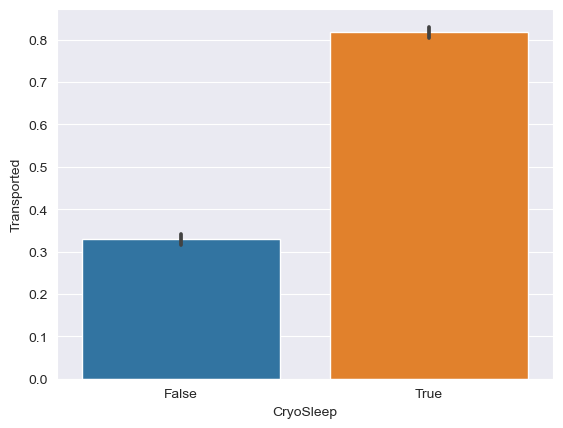

In [15]:
#Relationship between CryoSleep and Transported by percentage (not null)
sns.barplot(x='CryoSleep', y='Transported', data=data_v1)

In [16]:
# check if anyone who is in CryoSleep and had a room service, food court, shopping mall, spa or VR deck
data_v1[(data_v1['CryoSleep'] == True) & (data_v1['RoomService'] > 0) & (data_v1['FoodCourt'] > 0) & (data_v1['ShoppingMall'] > 0) & (data_v1['Spa'] > 0) & (data_v1['VRDeck'] > 0)]


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange,FirstName,LastName


there are no people who are in CryoSleep and had a room service, food court, shopping mall, spa or VR deck

In [17]:
# go through missing values in CryoSleep and fill them with them accordingly :
# if RoomService > 0 or FoodCourt > 0 or ShoppingMall > 0 or Spa > 0 or VRDeck > 0 then CryoSleep = False
print(data_v1[data_v1['CryoSleep'].isnull()].shape)
def fill_missing_cryo_sleep(data):
    for index, row in data.iterrows():
        cryo_sleep = row['CryoSleep']
        room_service = row['RoomService']
        food_court = row['FoodCourt']
        shopping_mall = row['ShoppingMall']
        spa = row['Spa']
        vr_deck = row['VRDeck']
        if pd.isnull(cryo_sleep):
            if room_service > 0 or food_court > 0 or shopping_mall > 0 or spa > 0 or vr_deck > 0:
                data.at[index, 'CryoSleep'] = False
    return data
data_v1 = fill_missing_cryo_sleep(data_v1)
cleaning_pipeline.append(fill_missing_cryo_sleep)
print(data_v1[data_v1['CryoSleep'].isnull()].shape)

(217, 19)
(98, 19)


more than half of the missing values in CryoSleep were filled and we will might come back to it later

In [18]:
data_v1[data_v1['CryoSleep'].isnull()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange,FirstName,LastName
92,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Thewis Connelson,True,99,2,2,0,Thewis,Connelson
111,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True,115,1,1,0,Rohs,Pead
175,Earth,NaN,G/30/P,PSO J318.5-22,52.0,False,0.0,0.0,0.0,0.0,0.0,Jeroy Cookson,True,198,1,1,0,Jeroy,Cookson
266,Europa,NaN,B/7/S,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Dhenar Excialing,True,290,3,4,0,Dhenar,Excialing
392,Europa,NaN,B/20/P,55 Cancri e,27.0,False,0.0,0.0,0.0,0.0,0.0,Hekark Mormonized,True,433,1,2,0,Hekark,Mormonized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8501,Earth,NaN,G/1461/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Shawne Simonsents,False,9076,1,1,9000,Shawne,Simonsents
8612,Earth,NaN,G/1483/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,0.0,0.0,Camily Howence,False,9193,1,1,9000,Camily,Howence
8620,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,0.0,0.0,Bellus Platch,True,9197,1,4,9000,Bellus,Platch
8651,Earth,NaN,G/1498/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,Hard Hinglendez,False,9227,5,5,9000,Hard,Hinglendez


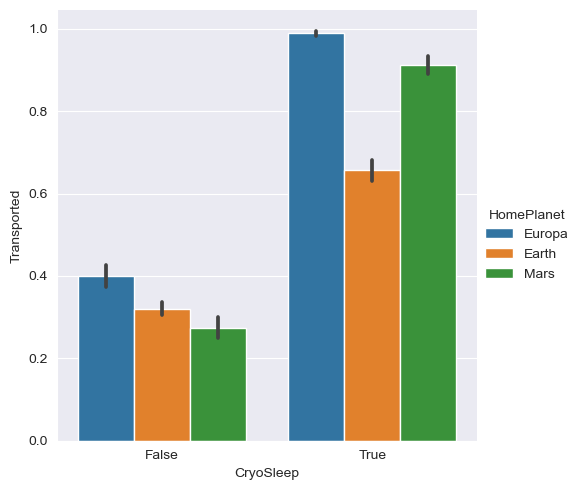

In [19]:
#Relationship between CryoSleep, HomePlanet and Transported by percentage
sns.catplot(x='CryoSleep', y='Transported', hue='HomePlanet', kind='bar', data=data_v1)


In [20]:
# Percentage of Transported by HomePlanet and CryoSleep
data_v1.groupby(['HomePlanet', 'CryoSleep'])['Transported'].mean().to_frame()

Transported
HomePlanet CryoSleep             
Earth      False         0.320505
           True          0.656738
Europa     False         0.398677
           True          0.989282
Mars       False         0.274223
           True          0.912917

some good information found we need to separate the HomePlanet into 3 different columns

In [21]:
def add_home_planet_columns(data):
    dummies = pd.get_dummies(data['HomePlanet'])
    data = pd.concat([data, dummies], axis=1)
    return data
cleaning_pipeline.append(add_home_planet_columns)
data_v1 = add_home_planet_columns(data_v1)

now let's work on Cabin

In [22]:
data_v1['Cabin'].isnull().sum()

199

In [23]:
# divide Cabin into 3 columns deck/num/side v1_data[Cabin] = F/15/S convert Num to int and Side to bool if Side == 'P' then True else False
def split_cabin(data):
    for index, row in data.iterrows():
        cabin = row['Cabin']
        if pd.isnull(cabin):
            continue
        cabin = cabin.split('/')
        deck = cabin[0]
        num = cabin[1]
        side = cabin[2]
        data.at[index, 'Deck'] = deck
        data.at[index, 'RoomNumber'] = int(num)
        data.at[index, 'PortSide'] = side == 'P'
    return data
cleaning_pipeline.append(split_cabin)
data_v1 = split_cabin(data_v1)

<Axes: xlabel='Deck', ylabel='count'>

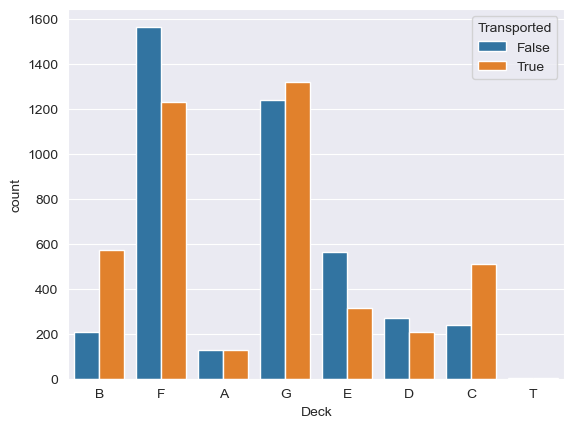

In [24]:
sns.countplot(x='Deck', hue='Transported', data=data_v1)

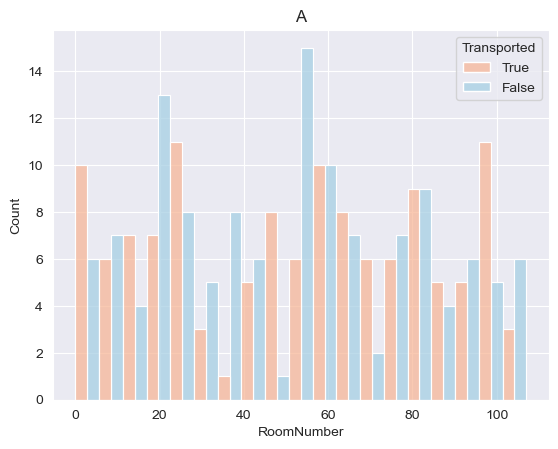

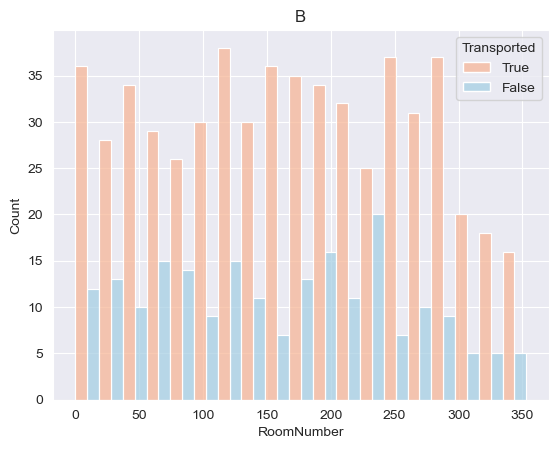

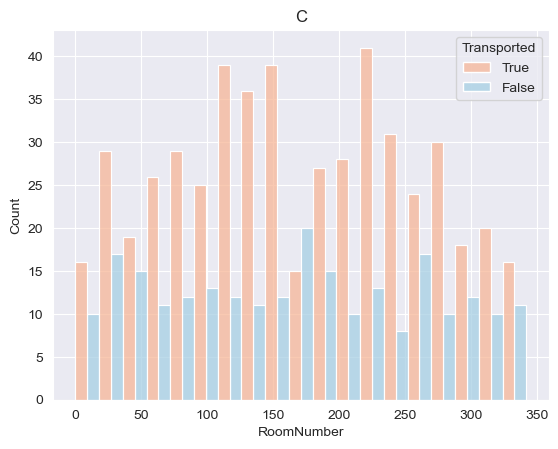

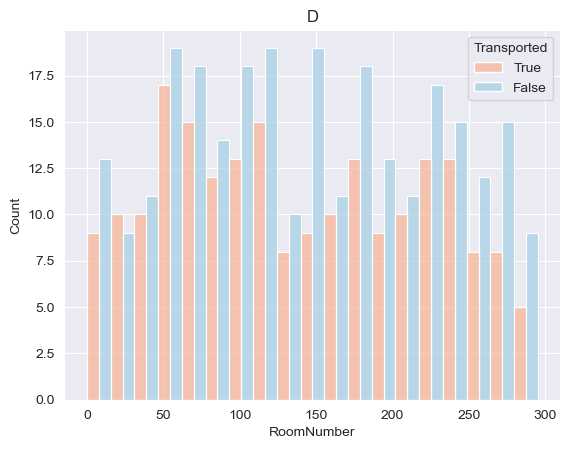

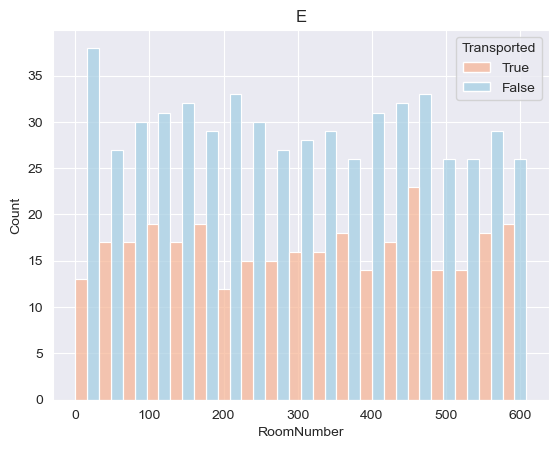

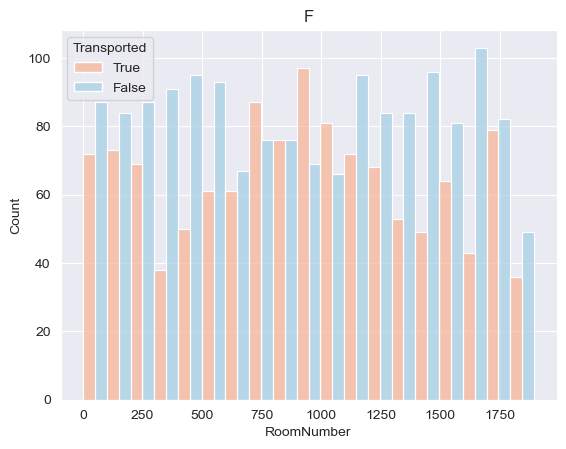

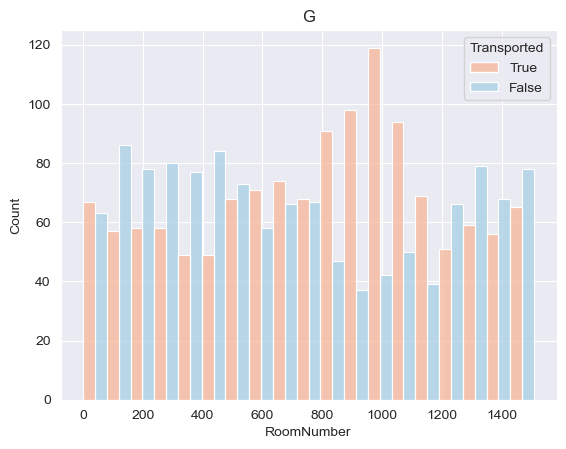

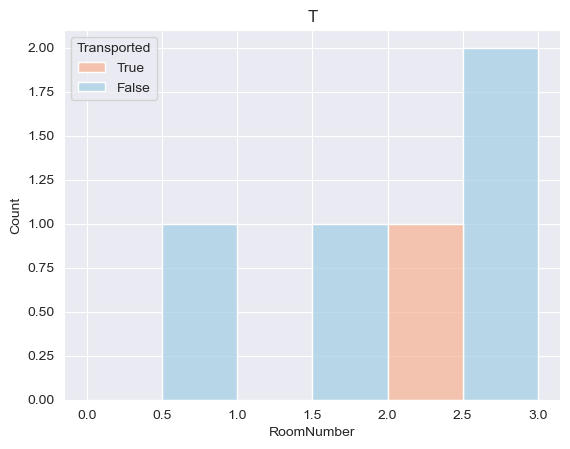

In [25]:

grouped_data = data_v1.groupby('Deck')
# Iterate over each deck and create separate plots
for deck, deck_data in grouped_data:
    # find min and max of 'RoomNumber' for each deck
    min_num = deck_data['RoomNumber'].min()
    max_num = deck_data['RoomNumber'].max()
    # Create a range of 'RoomNumber' between min and max inclusive and divide into 10 bins
    nums = np.linspace(min_num, max_num, int(min(20, max_num - min_num + 1)))
    sns.histplot(data=deck_data, x='RoomNumber', hue='Transported', palette='RdBu', hue_order=[True, False], bins=nums, multiple="dodge")
    plt.title(deck)
    plt.show()



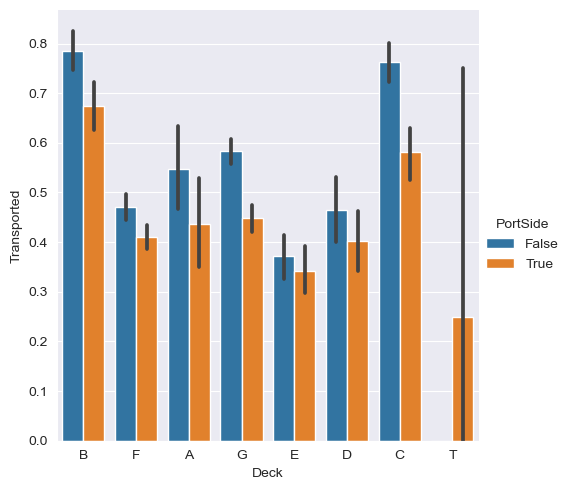

In [26]:
# Relationship between Deck(Divide by PortSide) and Transported by percentage
sns.catplot(x='Deck', y='Transported', hue='PortSide', kind='bar', data=data_v1)

In [27]:
# create a new column called CabinID and divide RoomNumber into min(20, max_num - min_num + 1) bins for each deck
def add_cabin_id(data):
    minMaxDict = {}
    for index, row in data.iterrows():
        deck = row['Deck']
        num = row['RoomNumber']
        if pd.isnull(deck) or pd.isnull(num):
            continue
        if deck not in minMaxDict:
            minMaxDict[deck] = [num, num]
        else:
            if num < minMaxDict[deck][0]:
                minMaxDict[deck][0] = num
            if num > minMaxDict[deck][1]:
                minMaxDict[deck][1] = num
    for index, row in data.iterrows():
        deck = row['Deck']
        num = row['RoomNumber']
        if pd.isnull(deck) or pd.isnull(num):
            continue
        min_num = minMaxDict[deck][0]
        max_num = minMaxDict[deck][1]
        nums = np.linspace(min_num, max_num, int(min(20, max_num - min_num + 1)))
        for i in range(len(nums) - 1):
            if nums[i] <= num <= nums[i + 1]:
                data.at[index, 'RoomID'] = i
                break
    return data
cleaning_pipeline.append(add_cabin_id)
data_v1 = add_cabin_id(data_v1)

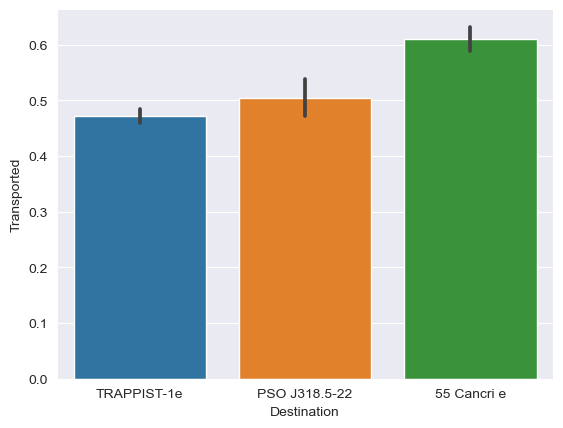

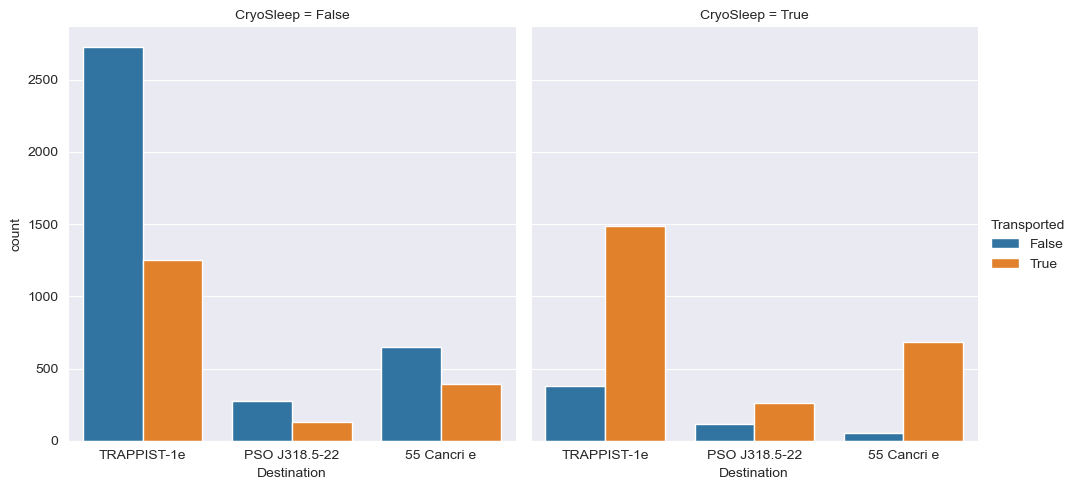

In [28]:
sns.barplot(x='Destination', y='Transported', data=data_v1)
sns.catplot(x='Destination', hue='Transported', col='CryoSleep', kind='count', data=data_v1)

Some groups have a higher percentage of transported than others, and It could be a good feature for RandomForest

In [29]:
# Checking for missing values in Destination
data_v1['Destination'].isnull().sum()

182

<Axes: xlabel='HomePlanet', ylabel='Transported'>

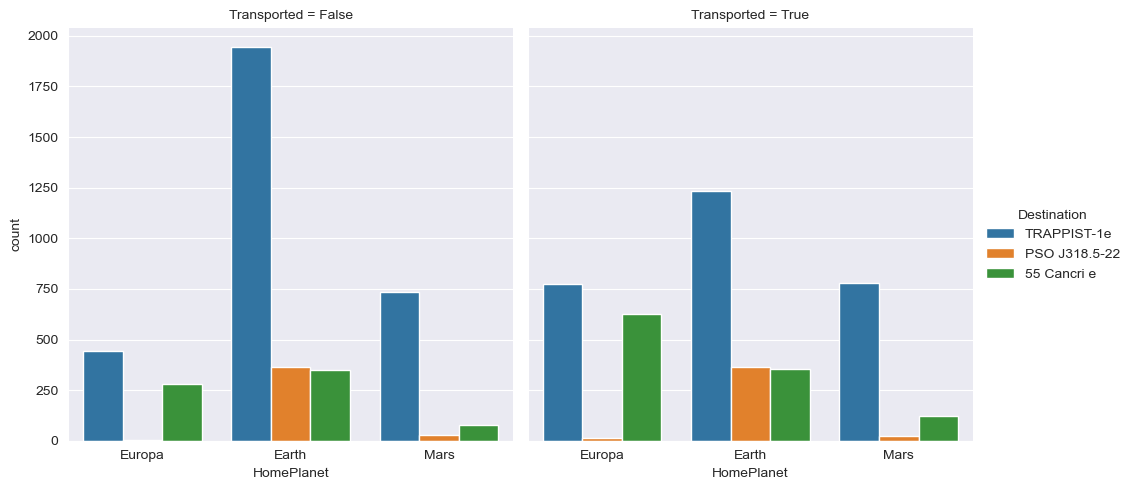

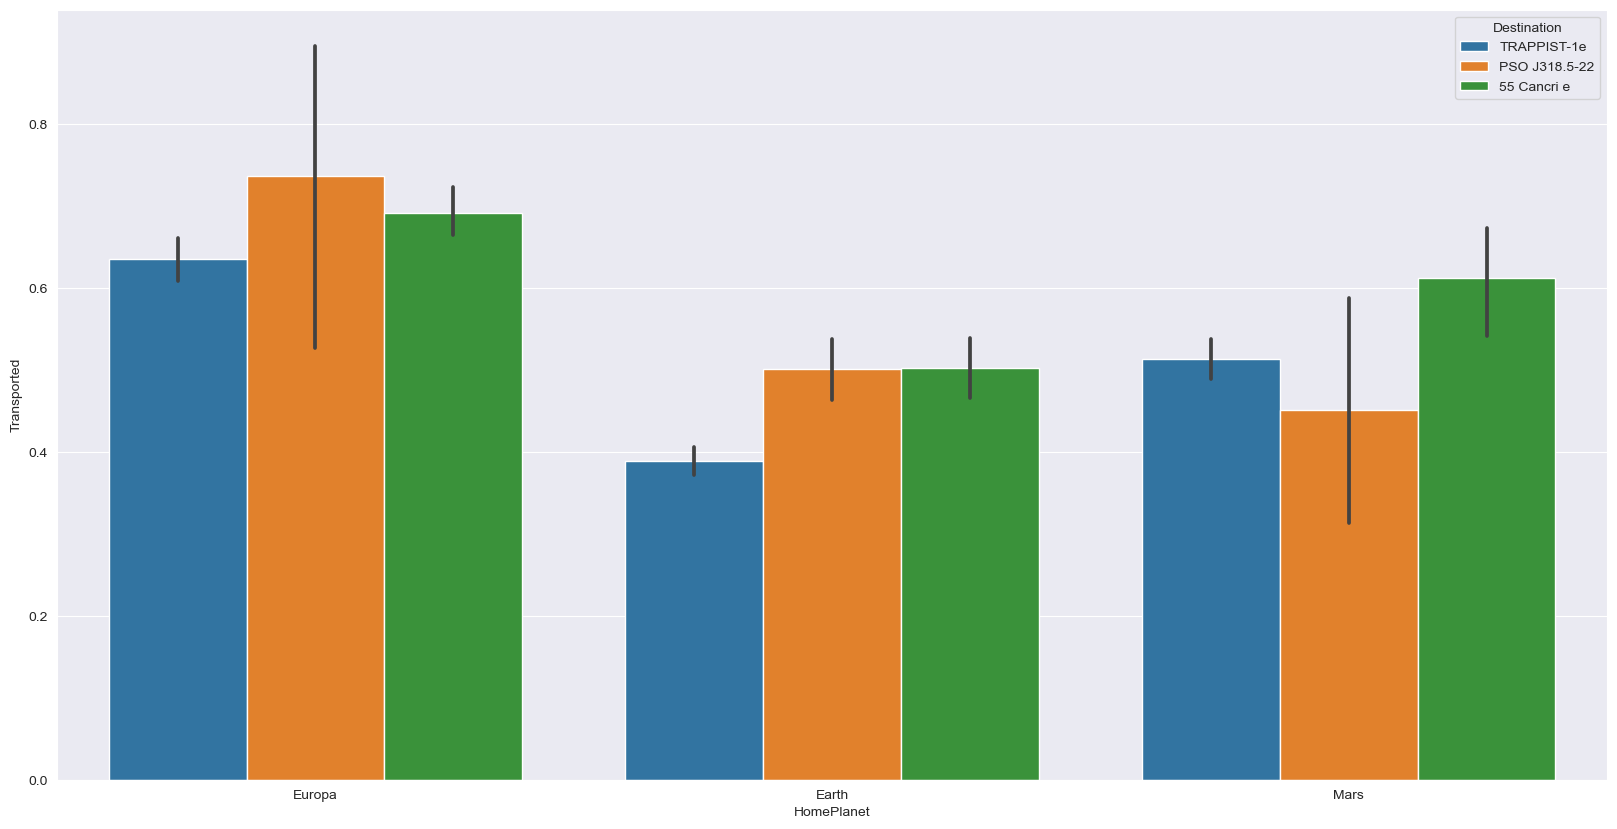

In [30]:
# Relationship between HomePlanet, Destination and Transported by count
sns.catplot(x='HomePlanet', hue='Destination', col='Transported', kind='count', data=data_v1)
# Relationship between HomePlanet, Destination and Transported by percentage
plt.figure(figsize=(20, 10))
sns.barplot(x='HomePlanet', y='Transported', hue='Destination', data=data_v1)

In [31]:
# We will fill the missing values in Destination with the most common value for each HomePlanet
def fill_missing_destination(data):
    for index, row in data.iterrows():
        destination = row['Destination']
        home_planet = row['HomePlanet']
        if pd.isnull(destination) :
            if pd.isnull(home_planet):
                data.at[index, 'Destination'] = data['Destination'].value_counts().idxmax()
            data.at[index, 'Destination'] = data[data['HomePlanet'] == home_planet]['Destination'].value_counts().idxmax()
    return data
cleaning_pipeline.append(fill_missing_destination)
data_v1 = fill_missing_destination(data_v1)

In [32]:
data_v1['Destination'].isnull().sum()

0

In [33]:
# fill the missing values in Age with the mean of Age
def fill_missing_age(data):
    data['Age']= data['Age'].fillna(data['Age'].mean())
    return data
# add a new column called AgeGroup (divide Age by 10)
data_v1 = fill_missing_age(data_v1)
cleaning_pipeline.append(fill_missing_age)
def add_age_group(data):
    data['AgeGroup'] = pd.cut(data['Age'], bins=[-1,15,31,47,1000], labels=['Infant','Child', 'Young', 'Adult'])
    return data
cleaning_pipeline.append(add_age_group)
data_v1 = add_age_group(data_v1)

In [34]:
data_v1['AgeGroup'].isnull().sum()

0

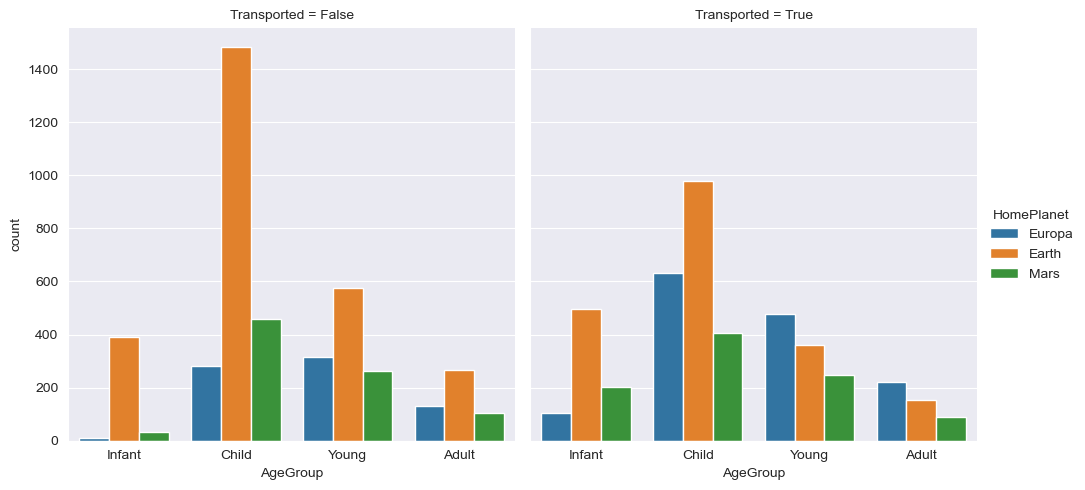

In [35]:
# Relationship between AgeGroup,CryoSleep and Transported by percentage
sns.catplot(x='AgeGroup', hue='HomePlanet', col='Transported', kind='count', data=data_v1)

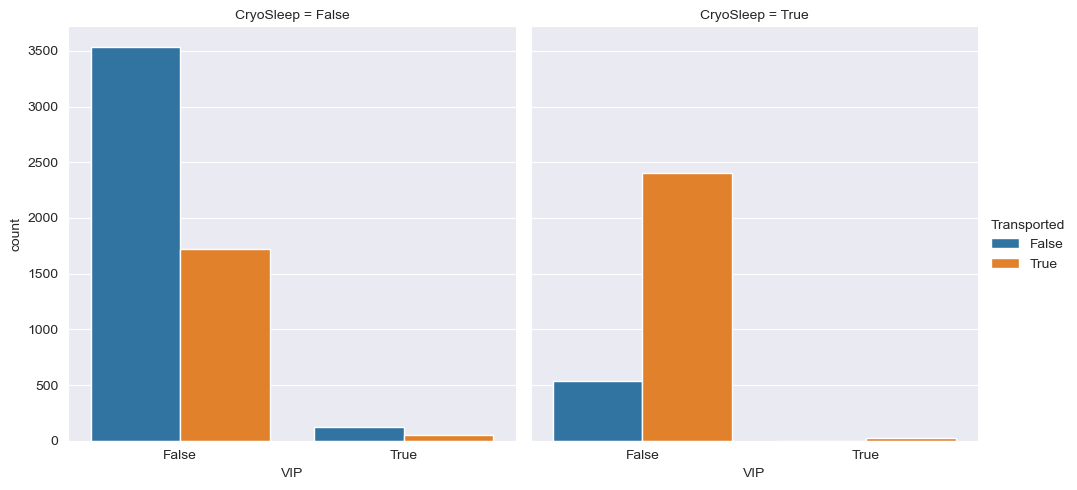

In [36]:
# Relationship between VIP,CryoSleep and Transported by count
sns.catplot(x='VIP', hue='Transported', col='CryoSleep', kind='count', data=data_v1)

In [37]:
# missing values in VIP
data_v1['VIP'].isnull().sum()

203

In [38]:
# fill the missing values in RoomService, FoodCourt, ShoppingMall, Spa, VRDeck with 0
def fill_missing_service(data):
    data['RoomService'].fillna(0, inplace=True)
    data['FoodCourt'].fillna(0, inplace=True)
    data['ShoppingMall'].fillna(0, inplace=True)
    data['Spa'].fillna(0, inplace=True)
    data['VRDeck'].fillna(0, inplace=True)
    return data
cleaning_pipeline.append(fill_missing_service)
data_v1 = fill_missing_service(data_v1)


In [39]:
def add_service_group(data):
    service_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    # For each column in service_cols, calculate the percentiles and create a new column
    for col in service_cols:
        # Select the rows where col > 0
        positive_values = data[data[col] > 0][col]

        # Calculate the 25%, 50% and 75% percentiles
        percentile_25 = np.percentile(positive_values, 25)
        percentile_50 = np.percentile(positive_values, 50)
        percentile_75 = np.percentile(positive_values, 75)

        # Create a new column with categories based on the percentiles
        data[col + 'Seed'] = pd.cut(data[col], bins=[-np.inf, 0, percentile_25, percentile_50, percentile_75, np.inf], labels=[0, 1, 2, 3, 4])
    return data
cleaning_pipeline.append(add_service_group)
data_v1 = add_service_group(data_v1)

In [40]:
def add_luxury_score(data):
    service_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    cat_cols = [col + 'Seed' for col in service_cols]
    data['LuxuryScore'] = data[cat_cols].sum(axis=1)
    return data
data_v1 = add_luxury_score(data_v1)
cleaning_pipeline.append(add_luxury_score)

Creating Pipeline for Test Data

In [41]:
# colms with missing values
data_v1.isnull().sum()
def drop_columns(data):
    data.drop(['Name', 'FirstName','LastName','HomePlanet', 'Cabin','Age','RoomNumber', 'RoomServiceSeed', 'FoodCourtSeed', 'ShoppingMallSeed', 'SpaSeed', 'VRDeckSeed'], axis=1, inplace=True)
    return data
cleaning_pipeline.append(drop_columns)
data_v1 = drop_columns(data_v1)
data_v1.isnull().sum()

CryoSleep        98
Destination       0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Group             0
Number            0
GroupSize         0
GroupRange        0
Earth             0
Europa            0
Mars              0
Deck            199
PortSide        199
RoomID          199
AgeGroup          0
LuxuryScore       0
dtype: int64

In [42]:
def fill_missing_deck(data):
    for index, row in data.iterrows():
        deck = row['Deck']
        destination = row['Destination']
        cryo_sleep = row['CryoSleep']
        if pd.isnull(deck):
            if pd.isnull(destination):
                data.at[index, 'Deck'] = data['Deck'].value_counts().idxmax()
            elif pd.isnull(cryo_sleep):
                data.at[index, 'Deck'] = data[data['Destination'] == destination]['Deck'].value_counts().idxmax()
            else:
                data.at[index, 'Deck'] = data[(data['Destination'] == destination) & (data['CryoSleep'] == cryo_sleep)]['Deck'].value_counts().idxmax()
    return data
cleaning_pipeline.append(fill_missing_deck)
data_v1 = fill_missing_deck(data_v1)
data_v1['Deck'].isnull().sum()

0

In [43]:
def fill_missing_portside(data):
    for index, row in data.iterrows():
        portside = row['PortSide']
        destination = row['Destination']
        if pd.isnull(portside):
            if pd.isnull(destination):
                data.at[index, 'PortSide'] = data['PortSide'].value_counts().idxmax()
            else:
                data.at[index, 'PortSide'] = data[data['Destination'] == destination]['PortSide'].value_counts().idxmax()
    return data
cleaning_pipeline.append(fill_missing_portside)
data_v1 = fill_missing_portside(data_v1)
data_v1['PortSide'].isnull().sum()

0

In [44]:
# fill the missing values in RoomID with -1
def fill_missing_room_id(data):
    data['RoomID']= data['RoomID'].fillna(-1)
    return data
cleaning_pipeline.append(fill_missing_room_id)
data_v1 = fill_missing_room_id(data_v1)
data_v1['RoomID'].isnull().sum()

0

In [45]:
# fill missing values in CryoSleep with the distribution percentage (True, False)
def fill_missing_cryosleep(data):
    data['CryoSleep']= data['CryoSleep'].fillna(data['CryoSleep'].value_counts(normalize=True).index[0])
    return data
cleaning_pipeline.append(fill_missing_cryosleep)
data_v1 = fill_missing_cryosleep(data_v1)

In [46]:
def encode_data(df, method='one_hot'):
    if method == 'one_hot':
        df_encoded = pd.get_dummies(df)
    elif method == 'ordinal':
        ordinal_encoder = OrdinalEncoder()
        df_encoded = pd.DataFrame(ordinal_encoder.fit_transform(df),
                                  columns=df.columns,
                                  index=df.index)
    else:
        raise ValueError("Method must be either 'one_hot' or 'ordinal'")
    df_encoded = df_encoded.astype(int)
    return df_encoded
cleaning_pipeline.append(encode_data)
data_v1 = encode_data(data_v1)
data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   CryoSleep                  8693 non-null   int32
 1   RoomService                8693 non-null   int32
 2   FoodCourt                  8693 non-null   int32
 3   ShoppingMall               8693 non-null   int32
 4   Spa                        8693 non-null   int32
 5   VRDeck                     8693 non-null   int32
 6   Transported                8693 non-null   int32
 7   Group                      8693 non-null   int32
 8   Number                     8693 non-null   int32
 9   GroupSize                  8693 non-null   int32
 10  GroupRange                 8693 non-null   int32
 11  Earth                      8693 non-null   int32
 12  Europa                     8693 non-null   int32
 13  Mars                       8693 non-null   int32
 14  RoomID                  

In [47]:
def remove_cols(data):
    data.drop(['Number','GroupRange'], axis=1, inplace=True)
    return data
cleaning_pipeline.append(remove_cols)
data_v1 = remove_cols(data_v1)


In [48]:
y = data_v1['Transported']
X = data_v1.drop('Transported', axis=1)

In [49]:
# Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=150, random_state=0)
rfc.fit(X, y)
rfc.score(X, y)

0.9944783158863454

In [83]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 5,20)
    random_state = trial.suggest_int('random_state', 0, 100 )

    rfc = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 random_state=random_state)

    cv_score = cross_val_score(rfc, X, y, cv=7, n_jobs=-1).mean()
    return cv_score

In [84]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, n_jobs=-1,show_progress_bar=True)
best_params = study.best_params
best_score = study.best_value
print(f'Best score: {best_score}\n')

[I 2023-07-23 20:34:56,274] A new study created in memory with name: no-name-d1e93e44-65c6-4b2a-944f-14b03276531c


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-07-23 20:35:02,844] Trial 1 finished with value: 0.7748716454353562 and parameters: {'n_estimators': 193, 'max_depth': 36, 'min_samples_split': 11, 'random_state': 86}. Best is trial 1 with value: 0.7748716454353562.
[I 2023-07-23 20:35:10,298] Trial 3 finished with value: 0.7765972513020827 and parameters: {'n_estimators': 133, 'max_depth': 22, 'min_samples_split': 8, 'random_state': 29}. Best is trial 3 with value: 0.7765972513020827.
[I 2023-07-23 20:35:11,883] Trial 0 finished with value: 0.7772874751118104 and parameters: {'n_estimators': 162, 'max_depth': 47, 'min_samples_split': 18, 'random_state': 7}. Best is trial 0 with value: 0.7772874751118104.
[I 2023-07-23 20:35:15,275] Trial 4 finished with value: 0.775102152567731 and parameters: {'n_estimators': 145, 'max_depth': 34, 'min_samples_split': 9, 'random_state': 81}. Best is trial 0 with value: 0.7772874751118104.
[I 2023-07-23 20:35:16,212] Trial 6 finished with value: 0.7778625843825717 and parameters: {'n_estimato

In [ ]:
# drop random_state from best_params
newBestParams = {k: v for k, v in best_params.items() if k != 'random_state'}
cur_best_score = [0,-1]
for i in range(100):
    rfc = RandomForestClassifier(**newBestParams, random_state=i)
    rfc.fit(X, y)
    score = rfc.score(X, y)
    if score > cur_best_score[0]:
        cur_best_score[0] = score
        cur_best_score[1] = i
print(f'Best score: {cur_best_score[0]}\nBest random_state: {cur_best_score[1]}')

In [92]:
rfc = RandomForestClassifier(**newBestParams, random_state=cur_best_score[1])
rfc.fit(X, y)

RandomForestClassifier(max_depth=28, min_samples_split=8, n_estimators=136,
                       random_state=94)

In [ ]:
catModel = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=True)
catModel.fit(X, y)
catModel.score(X, y)

In [101]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 100.00, log=True),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostClassifier(**params, verbose=False)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    accuracy = scores.mean()

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, show_progress_bar=True,n_jobs=-1)

best_trial = study.best_trial

[I 2023-07-23 21:03:36,198] A new study created in memory with name: no-name-563a532d-ce67-4b80-bcea-89b8e883fa88


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-07-23 21:03:48,676] Trial 0 finished with value: 0.7722307769170144 and parameters: {'iterations': 61, 'depth': 5, 'learning_rate': 0.006308007549049701, 'random_strength': 94, 'bagging_temperature': 12.662215456299528, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 0 with value: 0.7722307769170144.
[I 2023-07-23 21:03:53,189] Trial 7 finished with value: 0.7841933283085989 and parameters: {'iterations': 156, 'depth': 5, 'learning_rate': 0.01752783763527463, 'random_strength': 17, 'bagging_temperature': 14.989663236214426, 'od_type': 'IncToDec', 'od_wait': 41}. Best is trial 7 with value: 0.7841933283085989.
[I 2023-07-23 21:03:54,863] Trial 4 finished with value: 0.7667083776967968 and parameters: {'iterations': 239, 'depth': 4, 'learning_rate': 0.00367287386897948, 'random_strength': 57, 'bagging_temperature': 7.938152099611709, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 7 with value: 0.7841933283085989.
[I 2023-07-23 21:03:56,210] Trial 6 finished with value: 0.77361

In [589]:
print('Accuracy: {}'.format(best_trial.value))

Accuracy: 0.9889566317726907


In [103]:
catModel = CatBoostClassifier(iterations=best_trial.params['iterations'],
                              learning_rate=best_trial.params['learning_rate'],
                              depth=best_trial.params['depth'],
                              random_strength=best_trial.params['random_strength'],
                              bagging_temperature=best_trial.params['bagging_temperature'],
                              od_type=best_trial.params['od_type'],
                              od_wait=best_trial.params['od_wait'],
                              loss_function='Logloss',
                              verbose=True)
catModel.fit(X, y)
catModel.score(X, y)

0:	learn: 0.6628829	total: 7.67ms	remaining: 1.54s
1:	learn: 0.6365055	total: 15.8ms	remaining: 1.58s
2:	learn: 0.6160456	total: 22.7ms	remaining: 1.5s
3:	learn: 0.5978411	total: 29.5ms	remaining: 1.46s
4:	learn: 0.5815955	total: 37.6ms	remaining: 1.48s
5:	learn: 0.5644671	total: 46.9ms	remaining: 1.53s
6:	learn: 0.5491948	total: 55.2ms	remaining: 1.54s
7:	learn: 0.5369453	total: 63.1ms	remaining: 1.53s
8:	learn: 0.5270649	total: 70.6ms	remaining: 1.51s
9:	learn: 0.5182027	total: 79.3ms	remaining: 1.52s
10:	learn: 0.5078105	total: 86.4ms	remaining: 1.5s
11:	learn: 0.5005548	total: 94.3ms	remaining: 1.49s
12:	learn: 0.4941695	total: 102ms	remaining: 1.48s
13:	learn: 0.4880471	total: 108ms	remaining: 1.45s
14:	learn: 0.4829410	total: 115ms	remaining: 1.43s
15:	learn: 0.4754999	total: 122ms	remaining: 1.42s
16:	learn: 0.4712504	total: 129ms	remaining: 1.4s
17:	learn: 0.4648868	total: 136ms	remaining: 1.39s
18:	learn: 0.4607668	total: 143ms	remaining: 1.38s
19:	learn: 0.4573361	total: 149m

0.8594271252732083

In [104]:
# set up pipeline for test data
def clean_data(data):
    for func in cleaning_pipeline:
        data = func(data)
    return data
test_copy = test.copy(deep=True)
test_copy = clean_data(test_copy)

C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\2827957064.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data['Group'], data['Number'] = data['PassengerId'].str.split('_', 1).str
C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\2827957064.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['Group'], data['Number'] = data['PassengerId'].str.split('_', 1).str
C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\3706100281.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data['FirstName'], data['LastName'] = data['Name'].str.split(' ', 1).str
C:\Users\MJ\AppData\Local\Temp\ipykernel_12976\3706100281.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['FirstName'], data['LastName'] = data['Name'].str.split(' ', 1).

In [591]:
test_copy.columns

Index(['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Group', 'GroupSize', 'Earth', 'Europa', 'Mars', 'RoomID',
       'LuxuryScore', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'PortSide_False',
       'PortSide_True', 'AgeGroup_Infant', 'AgeGroup_Child', 'AgeGroup_Young',
       'AgeGroup_Adult'],
      dtype='object')

In [94]:
predictions = rfc.predict(test_copy)
# convert predictions to boolean

In [105]:
cat_pre = catModel.predict(test_copy)

In [106]:
cat_pre = [bool(x) for x in cat_pre]
# get xgb_pre to csv in the format required (0013_01,False)
answer = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': cat_pre})
#submission_dataVersion_modelName.csv
answer.to_csv('submission_v1_oneHot_cat.csv', index=False)

In [95]:
predictions = [bool(x) for x in predictions]
# get predictions to csv in the format required (0013_01,False)
answer = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': predictions})
#submission_dataVersion_modelName.csv
answer.to_csv('submission_v1_oneHot_rfc.csv', index=False)